# Model Interpretation (Section 2.3)

**Objective:** Understand what drives predictions and extract actionable insights

**Methods:**
- Feature Importance Rankings (Random Forest & Linear Regression)
- SHAP Values (SHapley Additive exPlanations)
- Partial Dependence Plots

---

## Setup and Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import TimeSeriesSplit, cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm.notebook import tqdm
import os

# Create visualizations folder
visualizations = 'visualizations'
os.makedirs(visualizations, exist_ok=True)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Initialize SHAP
shap.initjs()

print("✓ All packages loaded successfully!")

✓ All packages loaded successfully!


## 1. Data Loading and Preprocessing

In [2]:
print("="*70)
print("MODEL INTERPRETATION - SEOUL BIKE SHARING")
print("="*70)

print("\n[1/6] Loading and preprocessing data...")

df = pd.read_csv("SeoulBikeData.csv", encoding="latin1")
print(f"   ✓ Loaded {df.shape[0]} rows, {df.shape[1]} columns")

# Define target and features
y = df["Rented Bike Count"]
X = df.drop(columns=["Rented Bike Count"])

# Parse date and add calendar features
X["Date"] = pd.to_datetime(X["Date"], dayfirst=True, errors="coerce")
X["DayOfWeek"] = X["Date"].dt.dayofweek
X["Month"] = X["Date"].dt.month
X = X.drop(columns=["Date"])

# Encode categorical variables
X['Holiday_Encoded'] = X['Holiday'].map({'Holiday': 1, 'No Holiday': 0})
X['Functioning_Day_Encoded'] = X['Functioning Day'].map({'Yes': 1, 'No': 0})

# One-hot encoding for Seasons
season_dummies = pd.get_dummies(X['Seasons'], prefix='Season', drop_first=True, dtype=int)
X = pd.concat([X, season_dummies], axis=1)

# Drop original categorical columns and highly correlated feature
X = X.drop(columns=['Seasons', 'Holiday', 'Functioning Day', 'Dew point temperature(°C)'])

print(f"   ✓ Final feature set: {X.shape[1]} features")
print(f"\nFeature columns: {X.columns.tolist()}")

MODEL INTERPRETATION - SEOUL BIKE SHARING

[1/6] Loading and preprocessing data...
   ✓ Loaded 8760 rows, 14 columns
   ✓ Final feature set: 15 features

Feature columns: ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'DayOfWeek', 'Month', 'Holiday_Encoded', 'Functioning_Day_Encoded', 'Season_Spring', 'Season_Summer', 'Season_Winter']


## 2. Train Models

### 2.1 Linear Regression with Cross-Validation

In [3]:
print("\n[2/6] Training models...")

# Setup Time Series Cross-Validation
NUM_FOLDS = 5
tscv = TimeSeriesSplit(n_splits=NUM_FOLDS)

scoring = {
    'neg_mae': 'neg_mean_absolute_error',
    'neg_rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

# Linear Regression - Cross Validation
print("   Evaluating Linear Regression with cross-validation...")
lr_model_cv = LinearRegression()
lr_cv_results = cross_validate(
    lr_model_cv, X, y, 
    cv=tscv, 
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

print("\n   Cross-Validation Results (Linear Regression):")
print("   Fold |  Train R²  |  Test R²  | Test MAE | Test RMSE")
print("   " + "-"*60)
for fold in range(5):
    train_r2 = lr_cv_results['train_r2'][fold]
    test_r2 = lr_cv_results['test_r2'][fold]
    test_mae = -lr_cv_results['test_neg_mae'][fold]
    test_rmse = -lr_cv_results['test_neg_rmse'][fold]
    print(f"     {fold+1}  |   {train_r2:.4f}   |  {test_r2:.4f}  |  {test_mae:.2f}  |  {test_rmse:.2f}")

# Calculate mean and std across folds
lr_mean_r2 = lr_cv_results['test_r2'].mean()
lr_std_r2 = lr_cv_results['test_r2'].std()
lr_mean_mae = -lr_cv_results['test_neg_mae'].mean()
lr_std_mae = -lr_cv_results['test_neg_mae'].std()
lr_mean_rmse = -lr_cv_results['test_neg_rmse'].mean()
lr_std_rmse = -lr_cv_results['test_neg_rmse'].std()

print()
print(f"   Mean R²:    {lr_mean_r2:.4f} (+/- {lr_std_r2:.4f})")
print(f"   Mean MAE:   {lr_mean_mae:.2f} (+/- {lr_std_mae:.2f})")
print(f"   Mean RMSE:  {lr_mean_rmse:.2f} (+/- {lr_std_rmse:.2f})")

# NOW FIT ON FULL DATASET for interpretation
print("\n   Fitting Linear Regression on full dataset for interpretation...")
lr_model = LinearRegression()
lr_model.fit(X, y)
print("   ✓ Linear Regression trained on full dataset")


[2/6] Training models...
   Evaluating Linear Regression with cross-validation...

   Cross-Validation Results (Linear Regression):
   Fold |  Train R²  |  Test R²  | Test MAE | Test RMSE
   ------------------------------------------------------------
     1  |   0.3564   |  0.2669  |  178.49  |  280.72
     2  |   0.5292   |  0.2319  |  454.29  |  603.45
     3  |   0.5942   |  0.2539  |  508.70  |  630.76
     4  |   0.5760   |  0.3408  |  440.22  |  539.44
     5  |   0.5552   |  0.5169  |  301.92  |  411.11

   Mean R²:    0.3221 (+/- 0.1041)
   Mean MAE:   376.72 (+/- -120.30)
   Mean RMSE:  493.10 (+/- -130.46)

   Fitting Linear Regression on full dataset for interpretation...
   ✓ Linear Regression trained on full dataset


### 2.2 Random Forest

In [4]:
# Random Forest with optimal parameters
print("\n   Training Random Forest with optimal parameters (this may take a moment)...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Use tqdm to show progress during training
with tqdm(total=100, desc='RF Training') as pbar:
    rf_model.fit(X, y)
    pbar.update(100)

print("   ✓ Random Forest trained")


   Training Random Forest with optimal parameters (this may take a moment)...


RF Training:   0%|          | 0/100 [00:00<?, ?it/s]

   ✓ Random Forest trained


## 3. Feature Importance Analysis

### 3.1 Random Forest Feature Importance


[3/6] Analyzing feature importance...

   Top 10 Most Important Features (Random Forest):
   ------------------------------------------------------------------
   Temperature(°C)                     : 0.3047
   Hour                                : 0.2902
   Functioning_Day_Encoded             : 0.0874
   Solar Radiation (MJ/m2)             : 0.0867
   Humidity(%)                         : 0.0701
   Rainfall(mm)                        : 0.0467
   DayOfWeek                           : 0.0384
   Season_Winter                       : 0.0241
   Month                               : 0.0228
   Visibility (10m)                    : 0.0098
   ✓ Saved: feature_importance_rf.png


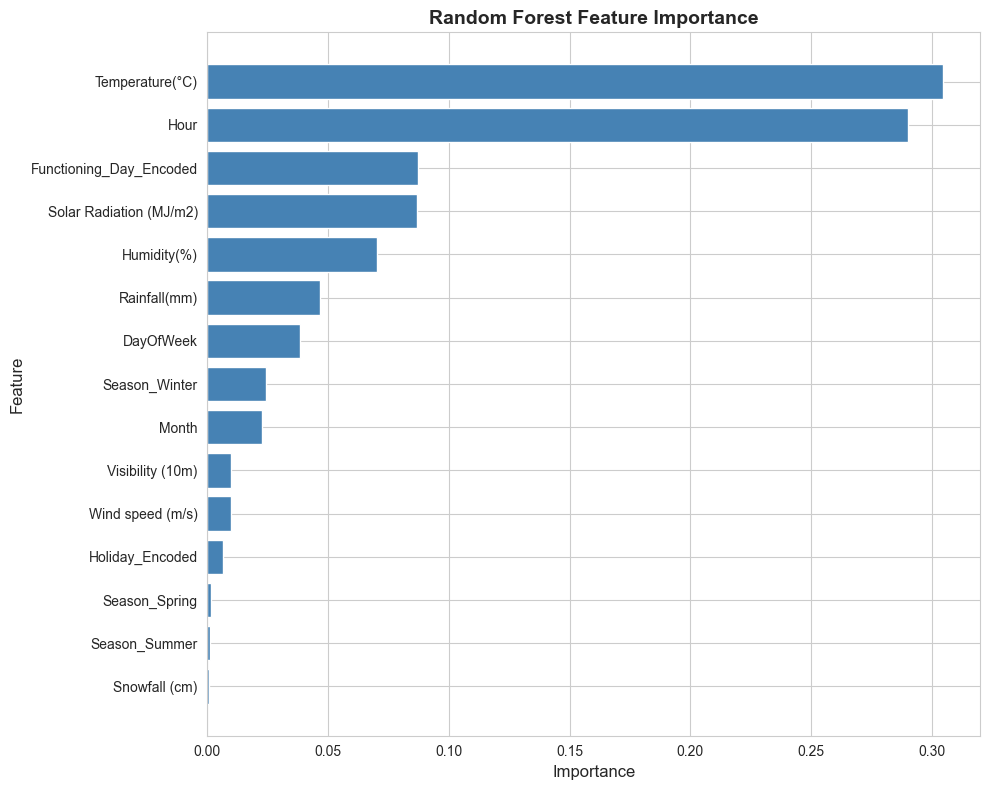

In [5]:
print("\n[3/6] Analyzing feature importance...")

# Random Forest Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n   Top 10 Most Important Features (Random Forest):")
print("   " + "-"*66)
for idx, row in feature_importance.head(10).iterrows():
    print(f"   {row['Feature']:35s} : {row['Importance']:.4f}")

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'{visualizations}/feature_importance_rf.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: feature_importance_rf.png")
plt.show()
plt.close()

### 3.2 Linear Regression Coefficients


   Top 5 Positive Contributors (Linear Regression):
   ------------------------------------------------------------------
   Functioning_Day_Encoded             : +931.75
   Hour                                : +27.44
   Snowfall (cm)                       : +26.74
   Temperature(°C)                     : +26.23
   Wind speed (m/s)                    : +18.59

   Top 5 Negative Contributors (Linear Regression):
   ------------------------------------------------------------------
   Solar Radiation (MJ/m2)             : -81.41
   Season_Spring                       : -112.34
   Holiday_Encoded                     : -124.91
   Season_Summer                       : -135.06
   Season_Winter                       : -349.46
   ✓ Saved: coefficients_lr.png


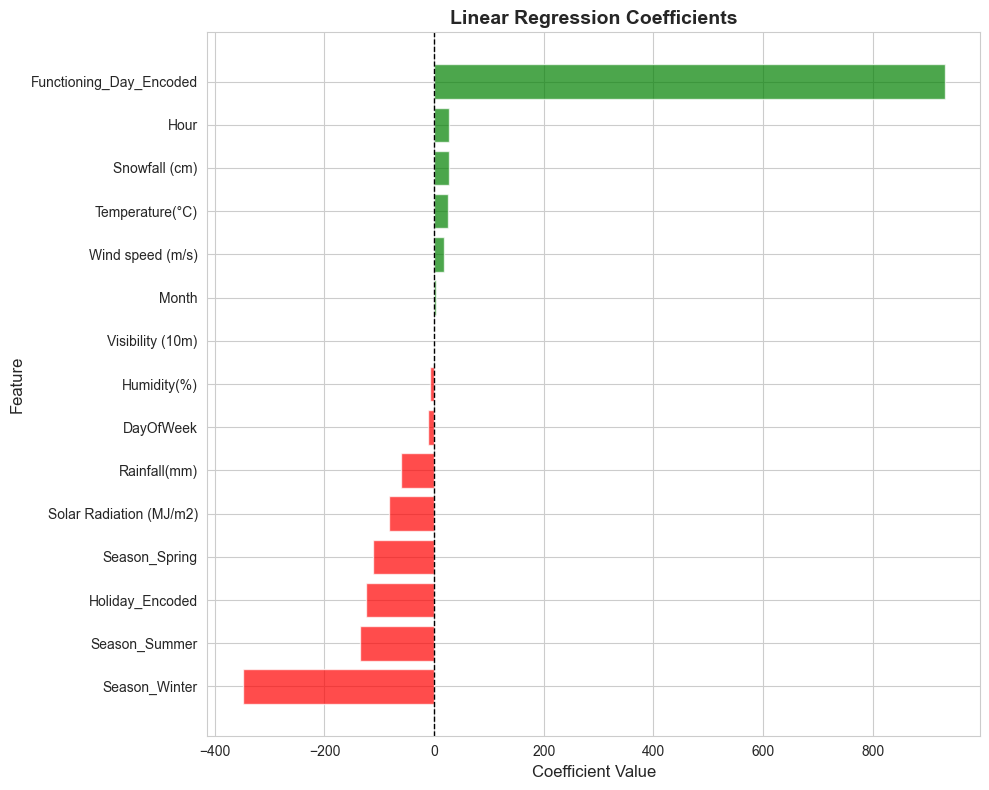

In [6]:
# Linear Regression Coefficients
lr_coef = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', ascending=False)

print("\n   Top 5 Positive Contributors (Linear Regression):")
print("   " + "-"*66)
for idx, row in lr_coef.head(5).iterrows():
    print(f"   {row['Feature']:35s} : {row['Coefficient']:+.2f}")

print("\n   Top 5 Negative Contributors (Linear Regression):")
print("   " + "-"*66)
for idx, row in lr_coef.tail(5).iterrows():
    print(f"   {row['Feature']:35s} : {row['Coefficient']:+.2f}")

# Visualize
plt.figure(figsize=(10, 8))
colors = ['green' if c > 0 else 'red' for c in lr_coef['Coefficient']]
plt.barh(lr_coef['Feature'], lr_coef['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Linear Regression Coefficients', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'{visualizations}/coefficients_lr.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: coefficients_lr.png")
plt.show()
plt.close()

## 4. SHAP Analysis

### 4.1 Compute SHAP Values

In [7]:
print("\n[4/6] Computing SHAP values (this may take a minute)...")

# Use sample for faster computation
sample_size = 1000
X_sample = X.sample(n=sample_size, random_state=42)

print(f"   Creating SHAP explainer...")
explainer_rf = shap.TreeExplainer(rf_model)

# Compute SHAP values in batches to show real progress
print(f"   Computing SHAP values for {sample_size} samples...")
batch_size = 100  # Process 100 samples at a time

shap_values_list = []
with tqdm(total=sample_size, desc="SHAP Progress", unit="samples") as pbar:
    for i in range(0, sample_size, batch_size):
        batch_end = min(i + batch_size, sample_size)
        batch = X_sample.iloc[i:batch_end]
        
        # Compute SHAP for this batch
        batch_shap = explainer_rf.shap_values(batch, check_additivity=False)
        shap_values_list.append(batch_shap)
        
        # Update progress bar
        pbar.update(batch_end - i)

# Combine all batches
shap_values_rf = np.vstack(shap_values_list)

print(f"   ✓ SHAP values computed for {sample_size} samples")


[4/6] Computing SHAP values (this may take a minute)...
   Creating SHAP explainer...
   Computing SHAP values for 1000 samples...


SHAP Progress:   0%|          | 0/1000 [00:00<?, ?samples/s]

   ✓ SHAP values computed for 1000 samples


### 4.2 SHAP Summary Plots


   Generating SHAP visualizations...
   ✓ Saved: shap_summary_dot.png


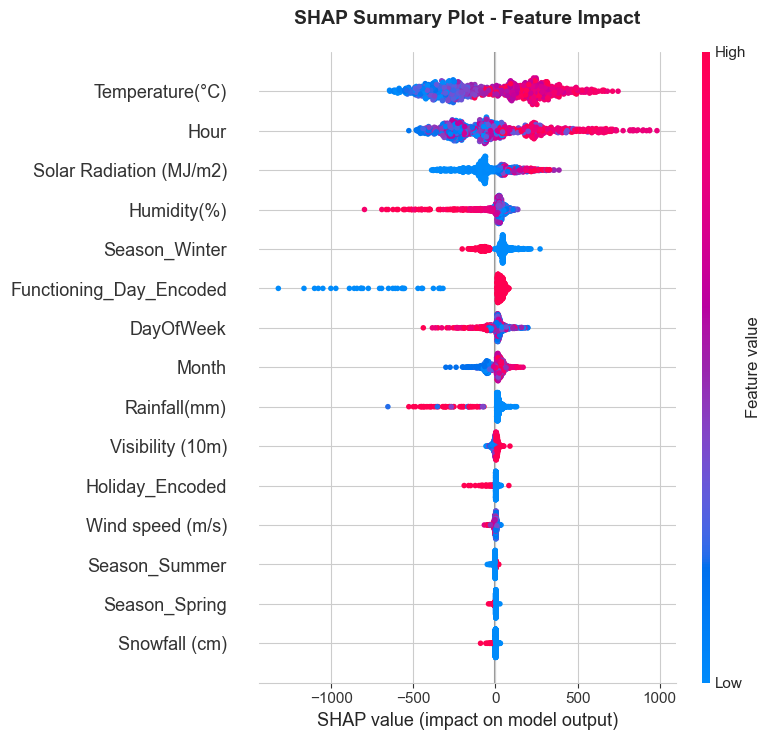

In [8]:
print("\n   Generating SHAP visualizations...")

# SHAP Summary Plot (dot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_rf, X_sample, plot_type="dot", show=False)
plt.title('SHAP Summary Plot - Feature Impact', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{visualizations}/shap_summary_dot.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: shap_summary_dot.png")
plt.show()
plt.close()

   ✓ Saved: shap_summary_bar.png


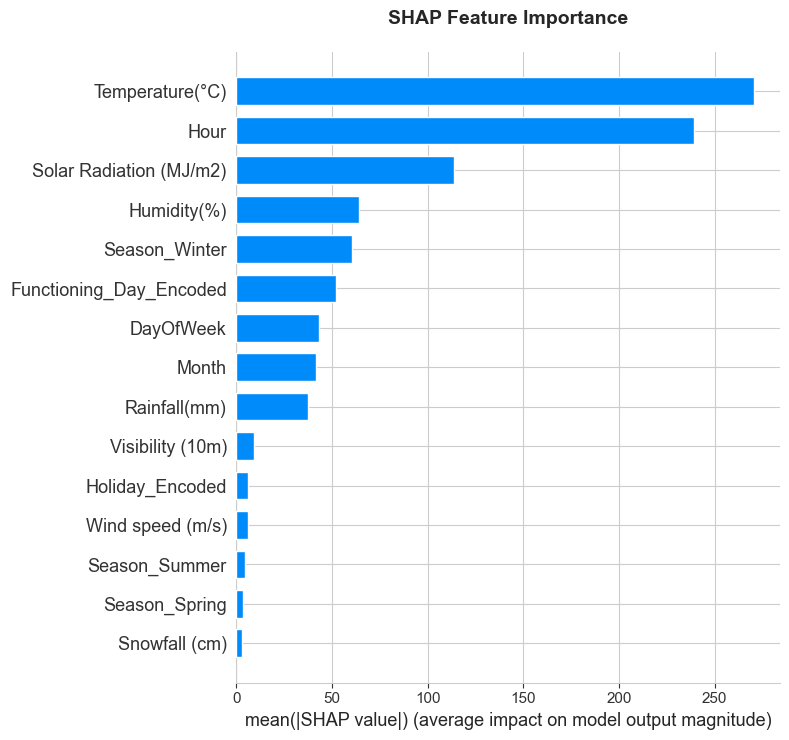

In [9]:
# SHAP Bar Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_rf, X_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{visualizations}/shap_summary_bar.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: shap_summary_bar.png")
plt.show()
plt.close()

### 4.3 SHAP Dependence Plots

   ✓ Saved: shap_dependence_plots.png


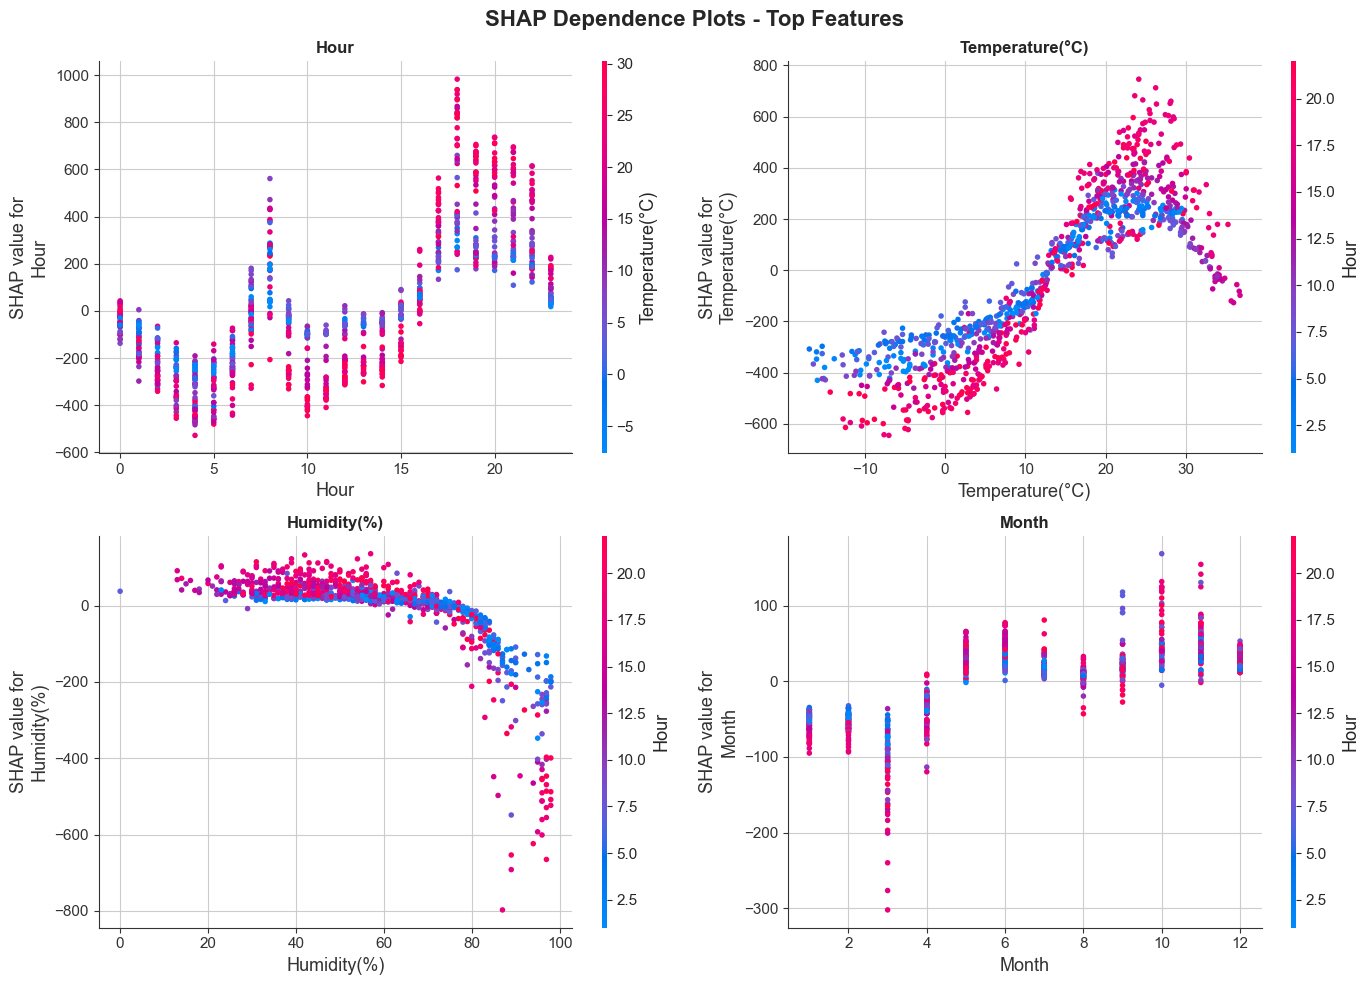

In [17]:
# SHAP Dependence Plots
top_features = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Month']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('SHAP Dependence Plots - Top Features', fontsize=16, fontweight='bold')

for idx, feature in enumerate(top_features):
    row = idx // 2
    col = idx % 2
    shap.dependence_plot(feature, shap_values_rf, X_sample, ax=axes[row, col], show=False)
    axes[row, col].set_title(f'{feature}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{visualizations}/shap_dependence_plots.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: shap_dependence_plots.png")
plt.show()
plt.close()

## 5. Partial Dependence Plots

### 5.1 1D Partial Dependence Plots


[5/6] Creating Partial Dependence Plots...


c:\Users\Anton\OneDrive\Desktop\WS25\DDS\dds_group_16\dds_venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
c:\Users\Anton\OneDrive\Desktop\WS25\DDS\dds_group_16\dds_venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


   ✓ Saved: partial_dependence_1d.png


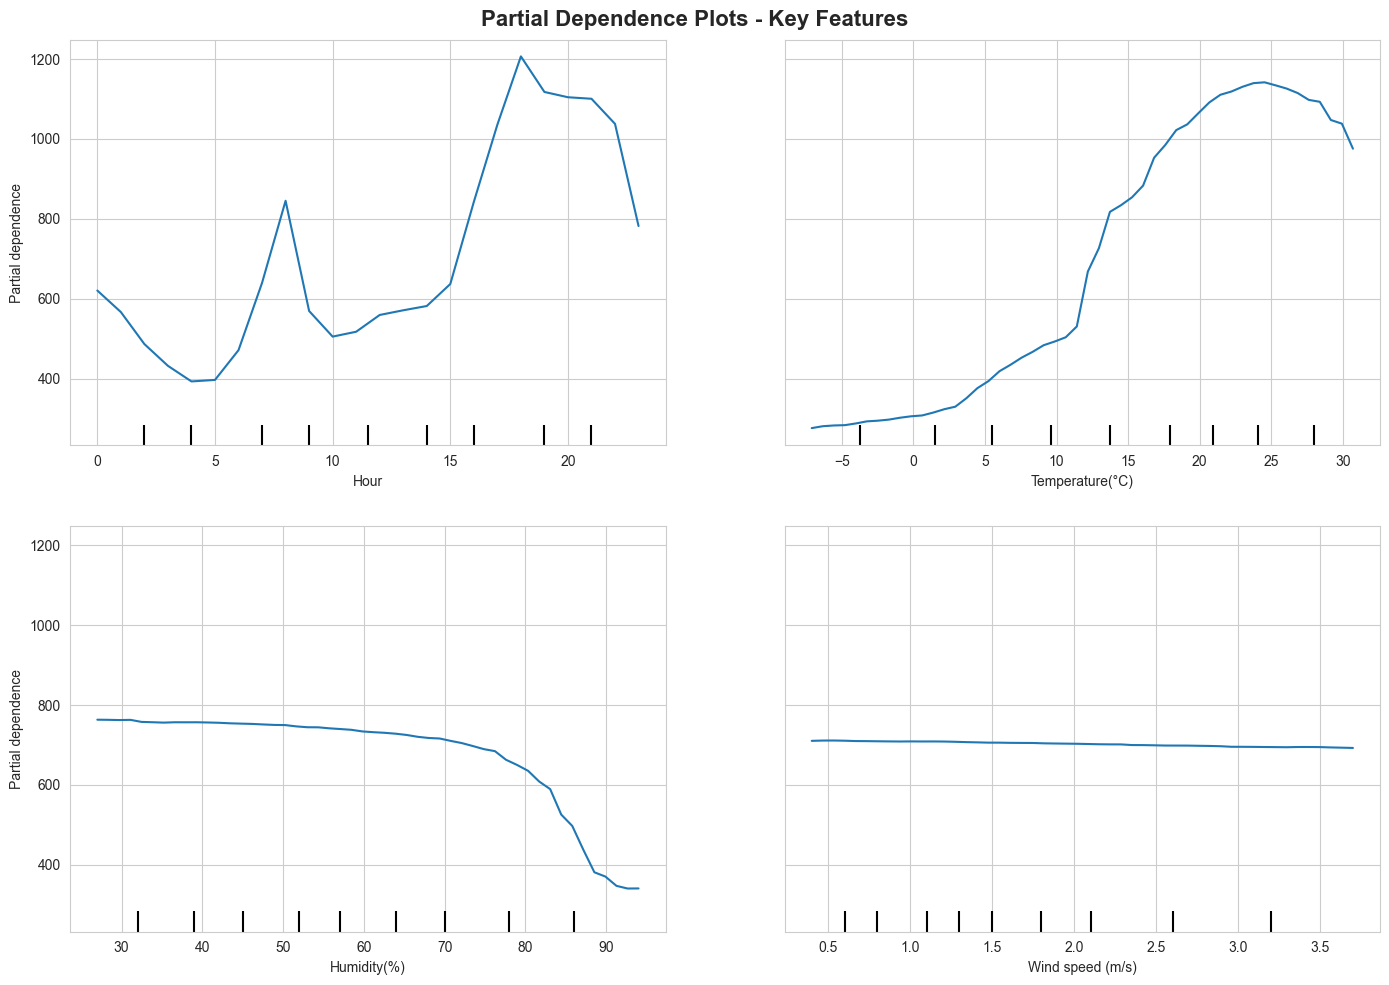

In [18]:
print("\n[5/6] Creating Partial Dependence Plots...")

# 1D PDPs
key_features = ['Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)']
feature_indices = [X.columns.get_loc(f) for f in key_features]

fig, ax = plt.subplots(figsize=(14, 10))
display = PartialDependenceDisplay.from_estimator(
    rf_model, X, features=feature_indices,
    feature_names=X.columns, n_cols=2, grid_resolution=50, ax=ax
)
fig.suptitle('Partial Dependence Plots - Key Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{visualizations}/partial_dependence_1d.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: partial_dependence_1d.png")
plt.show()
plt.close()

### 5.2 2D Partial Dependence Plot (Hour × Temperature)

c:\Users\Anton\OneDrive\Desktop\WS25\DDS\dds_group_16\dds_venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


   ✓ Saved: partial_dependence_2d.png


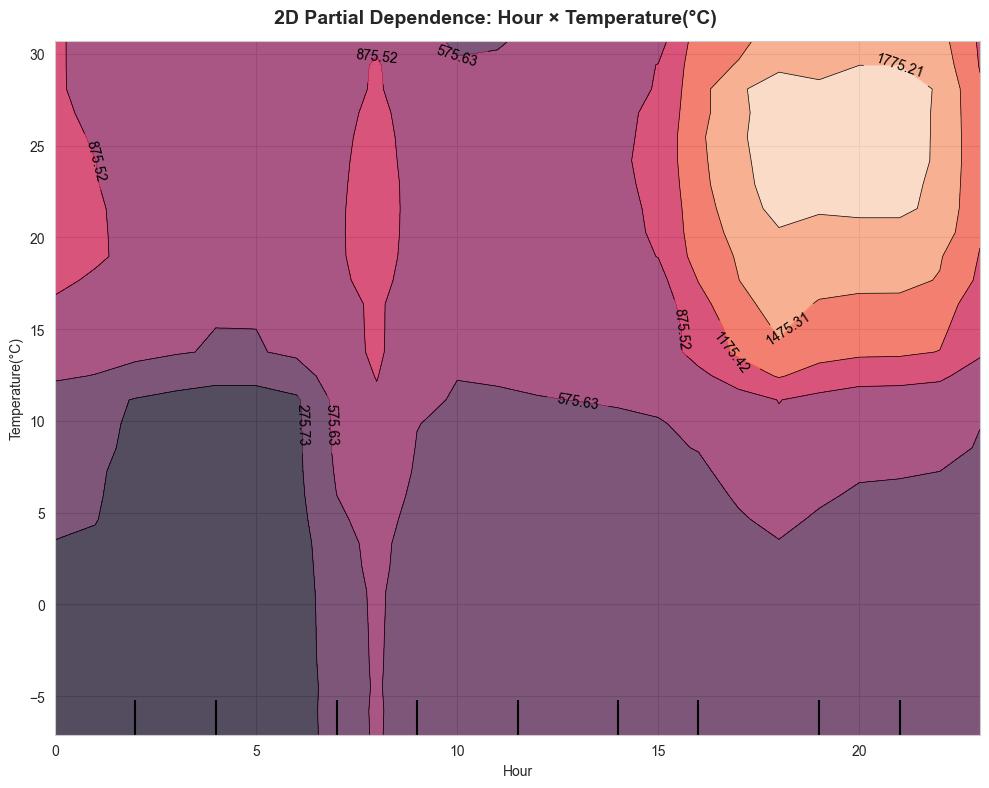

In [19]:
# 2D PDP: Hour × Temperature
fig, ax = plt.subplots(figsize=(10, 8))
display = PartialDependenceDisplay.from_estimator(
    rf_model, X, features=[(0, 1)],
    feature_names=X.columns, grid_resolution=30, ax=ax
)
plt.suptitle('2D Partial Dependence: Hour × Temperature(°C)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{visualizations}/partial_dependence_2d.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: partial_dependence_2d.png")
plt.show()
plt.close()